# Uporaba razdalj in podobnosti

V tem zvezku predstavimo, kako med prej dobljenimi vložitvami dokumentov računamo in uporabljamo razdalje in podobnosti.

Za začetek si spet preko API-ja pridobimo besedila zadnjih 100 predlogov vladi, ki vsebujejo vsaj 50 znakov ter iz datotek preberemo fastText in tf-idf vektorje iz prejšnjega primera.

In [2]:
from textsemantics.server_api import ServerAPI
import numpy as np
from scipy.sparse import load_npz

api = ServerAPI()
metadata = api.get_metadata('predlogi-vladi', sample_size=100, sampling_strategy='latest')

metadata = metadata[metadata["text"].apply(lambda x: len(x) > 50)]
titles = metadata['title']
texts = api.get_texts(urls=metadata['text'])

ft = np.load('data/ft.npy')
tfidf = load_npz('data/tfidf.npz').toarray()
word_embs = np.load('data/words.npy')

## Računanje razdalj med dokumenti

Razdaljo med dvema dokumentoma izračunamo kot razdaljo med njihovima vektorskima predstavitvama. Ker imamo mehanizem za računanje razdalj, lahko za želeni dokument poiščemo k dokumentov, ki so mu najbližji v vektorskem prostoru. Poiščimo 3 najbližje sosede enega dokumenta v našem seznamu.

In [3]:
def cos_sim(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

def knn(embs, ind=0, k=3):
    dists = [1 - cos_sim(embs[i], embs[ind]) if i != ind else 1
             for i in range(embs.shape[0])]
    inds = np.argsort(dists)
    return inds[:min(k, embs.shape[0])]

In [4]:
ft_nn = knn(ft, ind=20, k=3)
tfidf_nn = knn(tfidf, ind=20, k=3)

print(f'ID treh najbližjih sosedov za fastText {list(ft_nn)}')
print(f'ID treh najbližjih sosedov za vrečo besed {list(tfidf_nn)}')

ID treh najbližjih sosedov za fastText [7, 18, 30]
ID treh najbližjih sosedov za vrečo besed [30, 18, 7]


Izkaže se, da z uporabo obeh vložitev odkrijemo iste 3 najbližje sosede. Poglejmo besedila prvega dokumenta in njegovih najbližjih sosedov.


In [5]:
from IPython.display import Markdown, display
display(Markdown(
    f"## {titles[20]}\n{texts[20]}\n\n ## {titles[ft_nn[0]]}\n{texts[ft_nn[0]]}\n\n" +
    f"## {titles[ft_nn[1]]}\n{texts[ft_nn[1]]}\n\n ## {titles[ft_nn[2]]}\n{texts[ft_nn[2]]}\n\n"))


## Uvajanje anonimnih prijav za zbiranje skupin
Predlagam, da se uvede anonimno prijavljanje za zbiranje skupin na določenih mestih in sicer bolj natančno po vaseh, kajti vasi dejansko vsaj naš konec ne, sploh dejansko niso pod nekim nadzorom morebitnega širjenja okužb. Lokalni redar, ki ga imamo tukaj se samo vozi okoli mimo skupin ljudi brez mask, ki se kar nemalo krat zbirajo v gručah. Med njimi nekateri maske nosijo, drugi pa sploh ne. In to od jutra do mraka jeta miks popularna moda na našem koncu. Potem zvečer pride policija in naredi en krog in je dan zaključen. Torej, na podlagi tega predlagam to. Ljudje so obnašajo kot, da so sami na svetu in naj poudarim, da je kar nekaj takih ravno ostarelih ljudi tudi, ki so najbolj ogrožena skupina, med drugimi seveda.

 ## Podaljšanje šolanja na daljavo od 5. razreda naprej
Predlagam, da se šola na daljavo podaljša do konca prvega poletja v onovnih in srednjih šolah oz. prvega semestra na fakultetah. Šolo na daljavo predlagam od 5. razreda osnovne šole naprej, razen za učence s posebnimi potrebami in učno pomočjo. Najbolj se covid-19 da zajeziti s študiranjem na daljavo na fakultetah saj tam si gibljejo študenje iz različnih krajev, nenormalna gužva je na javnih prevozih in so tudi najbolj samostojni pri učenju na daljavo.

## Legalizirati evtanazijo
Predlagam, da se evtanazija legalizira. Kdor želi po svoji volji po poti evtanazije, naj se mu to omogoči.

 ## Kazen za policiste in redarje
Policisti, inšpektorji, redarji lovijo ljudi ki so brez mask in jih kaznujejo. Pojavlja pa se vse več fotografij in posnetkov ko ravno oni nimajo mask. Vlada naj zagotovi da se kaznuje tudi njih če je zadeva s temi maskami sploh resna.



Vsi štirje predlogi se nanašajo na šolanje na daljavo. Na takšen enostaven način lahko za poljuben predlog vladi poiščemo obstoječe predloge, ki so mu podobni.

Razdalje lahko dodatno poudarimo s hierarhičnim razvrščanjem. Izberimo si zgornje 4 preloge vladi in prve 4 predloge na seznamu ter narišimo dendrogram. 

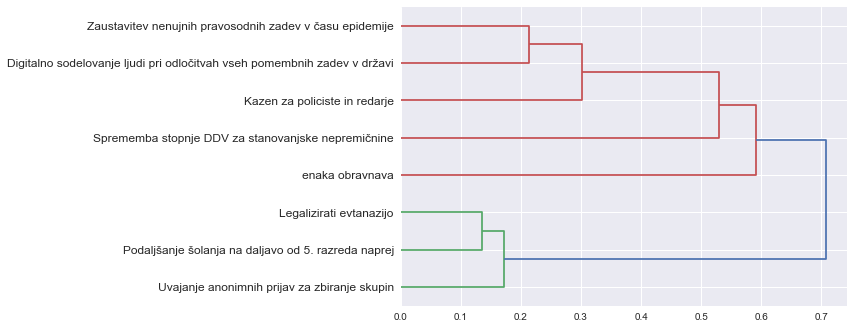

In [6]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt

plt.style.use('seaborn')

idx = list(ft_nn) + [20, 1, 2, 3, 4]
dist_mat = 1 - cosine_similarity(ft[idx, :])
linkage = ward(dist_mat)
_ = dendrogram(linkage, color_threshold=0.7, orientation='right', 
               labels=[titles[i] for i in [7, 18, 30, 20, 1, 2, 3, 4]])

Vidimo, da predlogi, ki govorijo o šolanju tvorijo eno skupino in da so med sabo bolj podobni kot dokumenti, ki tvorijo drugo skupino.

## Podobnost med dokumentom in besedo

Predpostavimo, da imamo seznam besed, za katere želimo vedeti, ali dobro opisujejo določeni dokument. To lahko izvemo na način podoben zgoraj opisanemu. Ker smo z modelom fastText dobili vložitve besed, nato pa le te združili v vložitve dokumentov, so tako besede kot dokumenti vektorji v istem vektorskem prostoru. Zato lahko računamo razdalje (podobnosti) med besedami in dokumenti. Vemo, da se zgornji predlog vladi nanaša na šolanje na daljavo. Izračunajmo kosinusno podobnost (definirana je kot 1 - razdalja) med tem predlogom in besedami šola, počitnice, semafor in tehnologija.

In [6]:
word_embs = np.load('data/words.npy')
for i, word in enumerate(['šola', 'počitnice', 'semafor', 'tehnologija']):
    print(f"Podobnost med dokumentom in besedo {word}: " + 
          f"{cos_sim(ft[0], word_embs[i, :]):.2f}")

Podobnost med dokumentom in besedo šola: 0.36
Podobnost med dokumentom in besedo počitnice: 0.41
Podobnost med dokumentom in besedo semafor: 0.31
Podobnost med dokumentom in besedo tehnologija: 0.35


Kot vidimo, sta besedi šola in počitnice bolj podobni dokumentu kot besedi semafor in tehnologija.